# LANL Earthquake Prediction

## Get Data and EDA:

First of all let's define some variables and basic functions

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from math import ceil

DATA_DIR = "data/"
TRAIN_DATA_DIR = os.path.join(DATA_DIR, "train/")
TEST_DATA_DIR = os.path.join(DATA_DIR, "test/")
SAMPLE_SIZE = 150000


train_files = os.listdir(TRAIN_DATA_DIR)
n_train_files = len(train_files)
test_files = os.listdir(TEST_DATA_DIR)
n_test_files = len(test_files)


# function that prints the progress of function
# based on the number of iterations and the 
# current iteration
def print_progress(it, n_elements):
    bit = ceil(n_elements / 100)
    if it % bit == 0:
            print(int(it / bit), end='.')
            
            
        



The training data for this project is huge it is a csv file containing 629145480 rows with two columns, corresponding to the acoustic data and the corresponding time to failure. Based on the test dataset, each sample is of the size of 150000 rows. To study the dataset we don't use all the dataset because it would be very slow and innecessary, thus let's try to use only 5 samples. For the training I divided the dataset into 4194 csv files, this helps with the memory usage

In [2]:
n_samples = 5
data = pd.read_csv(os.path.join(DATA_DIR, "train.csv"), nrows=SAMPLE_SIZE * n_samples)

In [3]:
data.head()

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691


Let's see a graphic representation of the acoutic_data, using a plot a histogram and a boxplot

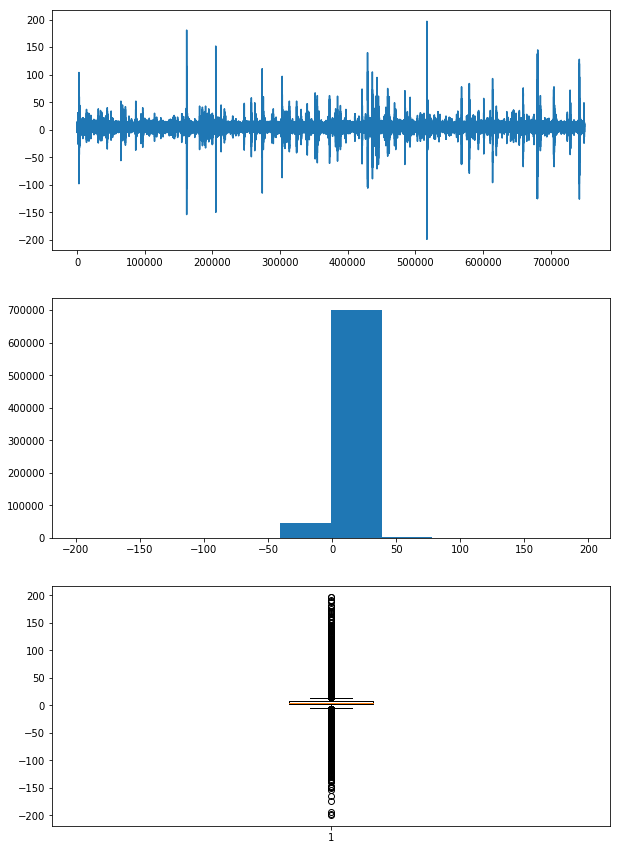

In [4]:
import matplotlib.pyplot as plt

plt.figure(1, figsize=(10, 15))
plt.subplot(311)
plt.plot(data["acoustic_data"])
plt.subplot(312)
plt.hist(data["acoustic_data"])
plt.subplot(313)
plt.boxplot(data["acoustic_data"])
plt.show()


The boxplot seems to have a very flattened box, it seems the values have a very close proximity although there are a lot of outliers. Let's look closer to the data by printing the percentiles and other estimates

In [5]:
from scipy import stats
from statsmodels import robust

def print_data(data):
    for i in range(0, 105, 5):
        print(str(i) + "%: ", np.percentile(data, i))
    print("iqr:", np.subtract(*np.percentile(data, [75, 25])))
    print("sd:", data.std())
    print("mean:", data.mean())
    print("var:", data.var())
    print("mad:", robust.mad(np.array(data)))
    print("trimmed_mean:", stats.trim_mean(np.array(data), 0.1))
    print("skew:", stats.skew(np.array(data)))
    print("kurtosis:", stats.kurtosis(np.array(data)))

We can see there is a lot of variability between percentiles. We can see that even if we trim 10% of the data the mean is almost exactly the same. That is because most of the data is very close together with the execption of some extremes values that cancel each other when computing the normal mean. We can see from kurtosis that the data has a propensity to have extreme values. We calculated that the data does not have a lot of skewnsess, we can see that to in the histogram

In [6]:
print_data(data["acoustic_data"])

0%:  -199.0
5%:  -2.0
10%:  0.0
15%:  1.0
20%:  2.0
25%:  2.0
30%:  3.0
35%:  3.0
40%:  4.0
45%:  4.0
50%:  5.0
55%:  5.0
60%:  6.0
65%:  6.0
70%:  7.0
75%:  7.0
80%:  8.0
85%:  9.0
90%:  10.0
95%:  12.0
100%:  197.0
iqr: 5.0
sd: 6.621580113104762
mean: 4.865446666666666
var: 43.84532319426447
mad: 2.965204437011204
trimmed_mean: 4.855716666666667
skew: 0.31673758988887757
kurtosis: 73.5997143942537


From the graph below we can see that there isn't too much correlation between the the acoustic data and the time to failure. By implementing new features for each sample based on data estimators we can develope more correlated features, thus making a better predictor

In [7]:
data.corr()

,acoustic_data,time_to_failure
acoustic_data,1.000000,-0.005397
time_to_failure,-0.005397,1.000000


As we can see from the following qqnorm, the samples do not have a normal distribution

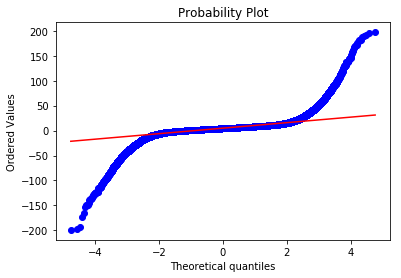

In [8]:
import pylab 
import scipy.stats as stats
  
stats.probplot(np.array(data["acoustic_data"]), dist="norm", plot=pylab)
pylab.show()

## Create dataset with all the features

Now that we have developed new features let's create a new dataset with each estimate

In [143]:
# define feature names
feature_columns = ["iqr", "mean", "sd", "var", "mad", "skew", "kurt"]
for i in range(0, 105, 5):
    feature_columns.append(str(i) + "%qt")
    
for windows in [10, 100, 1000]:
    feature_columns.append('ave_roll_std_' + str(windows))
    feature_columns.append('std_roll_std_' + str(windows))
    feature_columns.append('max_roll_std_' + str(windows))
    feature_columns.append('min_roll_std_' + str(windows))
    feature_columns.append('q01_roll_std_' + str(windows))
    feature_columns.append('q05_roll_std_' + str(windows))
    feature_columns.append('q95_roll_std_' + str(windows))
    feature_columns.append('q99_roll_std_' + str(windows))
    feature_columns.append('av_change_abs_roll_std_' + str(windows))
    feature_columns.append('abs_max_roll_std_' + str(windows))
    feature_columns.append('ave_roll_mean_' + str(windows))
    feature_columns.append('std_roll_mean_' + str(windows))
    feature_columns.append('max_roll_mean_' + str(windows))
    feature_columns.append('min_roll_mean_' + str(windows))
    feature_columns.append('q01_roll_mean_' + str(windows))
    feature_columns.append('q05_roll_mean_' + str(windows))
    feature_columns.append('q95_roll_mean_' + str(windows))
    feature_columns.append('q99_roll_mean_' + str(windows))
    feature_columns.append('av_change_abs_roll_mean_' + str(windows))
    feature_columns.append('abs_max_roll_mean_' + str(windows))

    
n_features = len(feature_columns)


X_data = pd.DataFrame(index=range(n_train_files), dtype=np.float32,
                       columns=feature_columns)

y_data = pd.DataFrame(index=range(n_train_files), dtype=np.float32,
                       columns=['time_to_failure'])

For now the dataset is empty, let't fill it in

In [144]:
X_data.head()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
y_data.head()

,time_to_failure
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


In [146]:

def make_dataset():
    for i, file in enumerate(train_files):
        print_progress(i, n_train_files)
        seg = pd.read_csv(os.path.join(TRAIN_DATA_DIR, file))
        # for each instance we set the target to the mean
        y_data.iloc[i]['time_to_failure'] = seg['time_to_failure'].mean()
        X_data.iloc[i][feature_columns[1]] = seg['acoustic_data'].mean()
        X_data.iloc[i][feature_columns[2]] = seg['acoustic_data'].std()
        X_data.iloc[i][feature_columns[3]] = seg['acoustic_data'].var()
        X_data.iloc[i][feature_columns[4]] = robust.mad(np.array(seg['acoustic_data']))
        X_data.iloc[i][feature_columns[5]] = stats.skew(np.array(seg['acoustic_data']))
        X_data.iloc[i][feature_columns[6]] = stats.kurtosis(np.array(seg['acoustic_data']))
        
        for windows in [10, 100, 1000]:
            x_roll_std =  pd.Series(seg['acoustic_data'].values).rolling(windows).std().dropna().values
            x_roll_mean =  pd.Series(seg['acoustic_data'].values).rolling(windows).mean().dropna().values

            X_data.loc[i]['ave_roll_std_' + str(windows)] = x_roll_std.mean()
            X_data.loc[i]['std_roll_std_' + str(windows)] = x_roll_std.std()
            X_data.loc[i]['max_roll_std_' + str(windows)] = x_roll_std.max()
            X_data.loc[i]['min_roll_std_' + str(windows)] = x_roll_std.min()
            X_data.loc[i]['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
            X_data.loc[i]['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
            X_data.loc[i]['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
            X_data.loc[i]['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
            X_data.loc[i]['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
            X_data.loc[i]['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

            X_data.loc[i]['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
            X_data.loc[i]['std_roll_mean_' + str(windows)] = x_roll_mean.std()
            X_data.loc[i]['max_roll_mean_' + str(windows)] = x_roll_mean.max()
            X_data.loc[i]['min_roll_mean_' + str(windows)] = x_roll_mean.min()
            X_data.loc[i]['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
            X_data.loc[i]['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
            X_data.loc[i]['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
            X_data.loc[i]['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
            X_data.loc[i]['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
            X_data.loc[i]['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()

        for j in range(0, 105, 5):
            X_data.iloc[i][str(j) + "%qt"] = np.percentile(seg['acoustic_data'], j)
        X_data.iloc[i][feature_columns[0]] = X_data.iloc[i]["75%qt"] - X_data.iloc[i]["25%qt"]  

In [147]:
# make data
make_dataset()

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.98.99.

In [148]:
# save data to disk
X_data.to_csv(path_or_buf=os.path.join(DATA_DIR, "train_data.csv"), header=True, sep=",", index=False)
y_data.to_csv(path_or_buf=os.path.join(DATA_DIR, "train_labels.csv"), header=True, sep=",", index=False)

In [151]:
# laod data from disk
# X_data = pd.read_csv(os.path.join(DATA_DIR, "train_data.csv"))
# y_data = pd.read_csv(os.path.join(DATA_DIR, "train_labels.csv"))

In [152]:
X_data.head()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.0,4.422187,3.780333,14.290920,2.965205,-0.046680,28.369833,-66.0,-1.0,1.0,...,4.422522,0.224015,5.111,3.602,3.916,4.077,4.794,4.931,-8.859061e-07,5.111
1,5.0,4.493220,4.994762,24.947640,2.965205,0.036164,21.434687,-80.0,-2.0,0.0,...,4.493222,0.229726,5.196,3.844,4.005,4.128,4.891,5.051,-6.228188e-06,5.196
2,10.0,4.733567,125.621030,15780.644000,7.413011,0.503524,130.496150,-2699.0,-30.0,-12.0,...,4.733405,1.870187,35.319,-25.103,-0.704,3.733,5.908,10.258,2.281879e-07,35.319
3,4.0,4.620747,4.154230,17.257630,2.965205,-0.095299,28.962673,-72.0,-1.0,1.0,...,4.622467,0.351742,5.348,3.574,3.740,3.975,5.106,5.263,1.872483e-06,5.348
4,4.0,4.278367,3.637350,13.230313,2.965205,0.246607,48.889263,-86.0,-1.0,1.0,...,4.278739,0.260738,5.080,3.551,3.732,3.874,4.736,4.918,5.906040e-07,5.080


In [153]:
y_data.head()

,time_to_failure
0,7.662949
1,2.029041
2,0.298690
3,4.722456
4,6.922673


In [154]:
X_data.corr()

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
iqr,1.000000,-0.009812,0.537231,0.410522,0.600356,0.021261,0.175292,-0.487887,-0.748355,-0.776232,...,-0.009744,0.428190,0.438237,-0.437792,-0.371573,-0.169761,0.130842,0.342355,-0.005770,0.438237
mean,-0.009812,1.000000,0.010820,0.010008,0.004934,-0.002517,-0.001545,-0.006316,0.106962,0.240534,...,0.999988,0.014316,0.091174,0.100297,0.515521,0.916734,0.933774,0.597466,0.003627,0.091174
sd,0.537231,0.010820,1.000000,0.956127,0.467617,0.055543,0.333802,-0.963867,-0.876972,-0.743168,...,0.011237,0.907130,0.949747,-0.954084,-0.758859,-0.268339,0.239889,0.720341,-0.083912,0.949747
var,0.410522,0.010008,0.956127,1.000000,0.326804,0.029222,0.183733,-0.904037,-0.785424,-0.632966,...,0.010462,0.939392,0.951774,-0.955905,-0.794548,-0.277607,0.245352,0.740951,-0.090695,0.951774
mad,0.600356,0.004934,0.467617,0.326804,1.000000,0.027320,0.197893,-0.434505,-0.679248,-0.703946,...,0.004970,0.338314,0.361499,-0.364054,-0.286020,-0.124103,0.116222,0.274698,-0.010976,0.361499
skew,0.021261,-0.002517,0.055543,0.029222,0.027320,1.000000,0.144331,-0.006328,-0.035912,-0.030746,...,-0.002476,0.018926,0.030619,-0.035462,-0.020706,-0.011176,0.001959,0.027146,-0.015912,0.030619
kurt,0.175292,-0.001545,0.333802,0.183733,0.197893,0.144331,1.000000,-0.463737,-0.240755,-0.220238,...,-0.001515,0.172808,0.270811,-0.277989,-0.132016,-0.045031,0.034692,0.123722,-0.007556,0.270811
0%qt,-0.487887,-0.006316,-0.963867,-0.904037,-0.434505,-0.006328,-0.463737,1.000000,0.814567,0.684149,...,-0.006701,-0.873725,-0.933443,0.937743,0.724281,0.257732,-0.226616,-0.666382,0.078587,-0.933443
5%qt,-0.748355,0.106962,-0.876972,-0.785424,-0.679248,-0.035912,-0.240755,0.814567,1.000000,0.925801,...,0.106712,-0.782571,-0.785459,0.811271,0.720995,0.366803,-0.124510,-0.563606,0.055152,-0.785459
10%qt,-0.776232,0.240534,-0.743168,-0.632966,-0.703946,-0.030746,-0.220238,0.684149,0.925801,1.000000,...,0.240417,-0.639742,-0.632397,0.680474,0.674005,0.450222,0.026172,-0.374545,0.034081,-0.632397


## Model Selection

Before selecting a model lets split the dataset into training and testing set and normalize the values

In [155]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_data = scaler.fit_transform(X_data)

X_train, X_test, y_train, y_test = train_test_split(
     X_data, y_data, test_size=0.2, random_state=42)

In [156]:
def display_feature_importances(importances):

    importances *= 100
    # sort feature importances in descending order
    indices = np.argsort(importances)[::-1]

    # rearrange feature names so that they match the sorted feature importances
    names = [feature_columns[i] for i in indices]

    # create plot
    plt.figure(figsize=(15,10))
    plt.title("Feature importances")

    # add bars
    plt.bar(range(X_train.shape[1]), importances[indices], color="#dd7831")
    plt.xticks(range(X_train.shape[1]), names, rotation=90)

    # show plot
    plt.show()

### DecisionTreeRegressor

In [165]:
from sklearn.tree import DecisionTreeRegressor

model_dtr = DecisionTreeRegressor(random_state=42, criterion="mae")

model_dtr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mae', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [166]:
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

def display_cross_val_score(model, X, y):
    scores = cross_val_score(model, X, y, cv=10, n_jobs=-1, scoring="neg_mean_absolute_error")
    print("Scores:", -scores)
    print("Mean:", -scores.mean())
    print("Standard deviation:", scores.std())

In [167]:
display_cross_val_score(model_dtr, X_test, y_test)

Scores: [2.83707085 3.09931824 2.55714769 3.37870746 3.08631475 2.92562356
 2.87349162 2.80643986 2.71348441 2.58405689]
Mean: 2.8861655330863742
Standard deviation: 0.2383099906362429


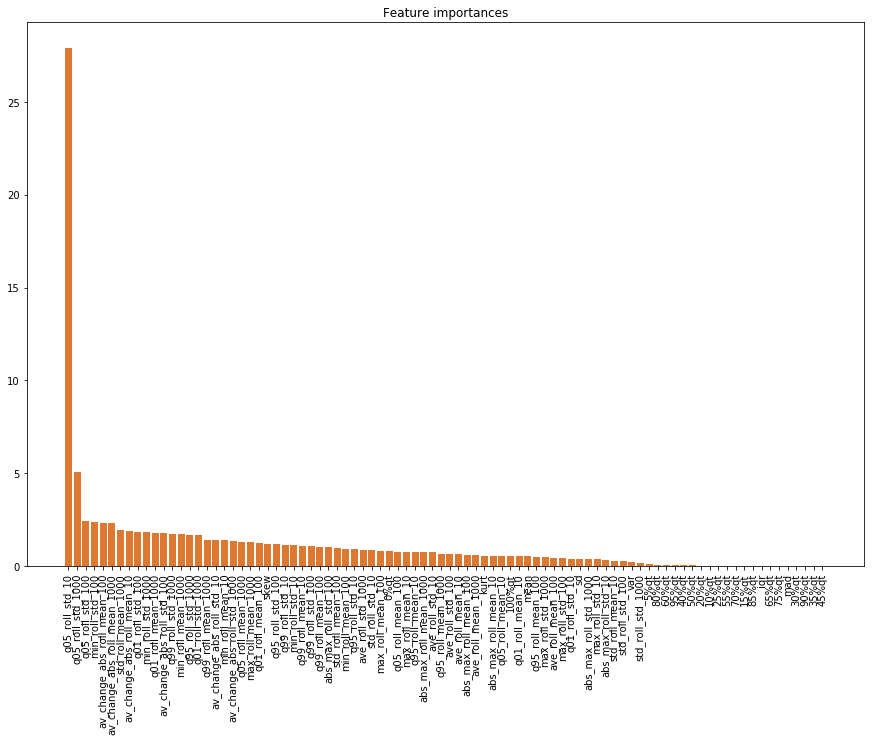

In [168]:
display_feature_importances(model_dtr.feature_importances_)

### RandomForestRegressor

In [157]:
from sklearn.ensemble import RandomForestRegressor

model_rfr = RandomForestRegressor(random_state=42, n_estimators=1000, n_jobs=-1)

In [158]:
model_rfr.fit(X_train, np.array(y_train).reshape(-1))

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=-1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [159]:
display_cross_val_score(model_rfr, X_test, y_test)

Scores: [2.29149733 2.25687452 1.89478691 2.31814157 1.90579836 1.8579422
 1.95383246 2.19881323 2.04565085 1.95012882]
Mean: 2.067346624677138
Standard deviation: 0.17122121201754972


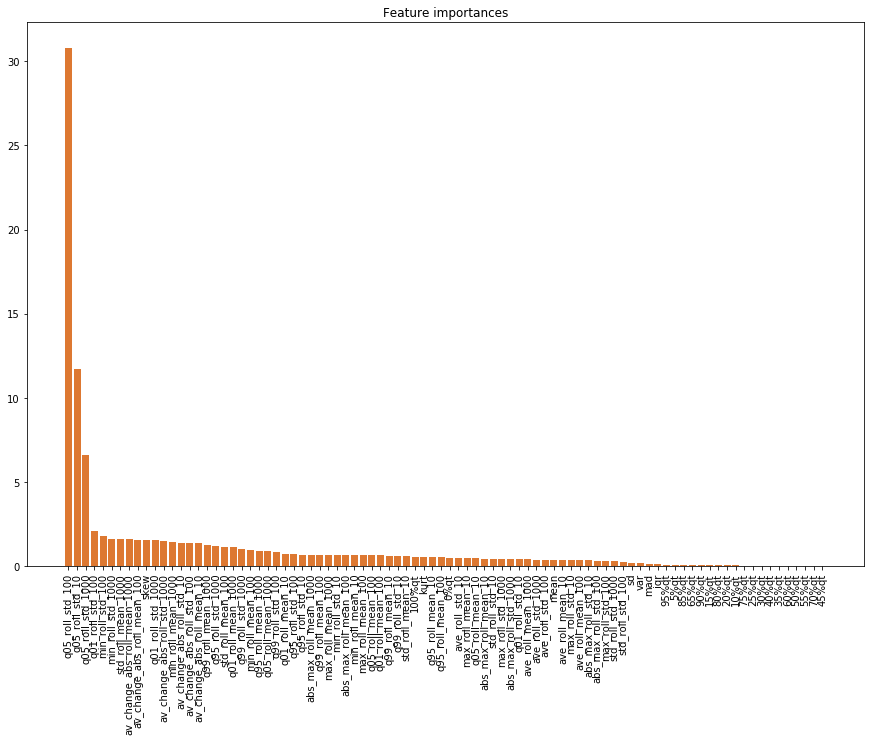

In [160]:
display_feature_importances(model_rfr.feature_importances_)

In [161]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, model_rfr.predict(X_test))

2.0671770250488786

In [207]:
from sklearn.externals import joblib
# save model
joblib.dump(model_rfr, "models/model_rfr.pkl")

['models/model_rfr.pkl']

### AdaBoost Decision Tree

Let's try the adaboost ensemble estimator with a DecisionTreeRegressor, to reduce overfitting we can reduce the number of estimators or relugarize the base estimator

In [162]:
from sklearn.ensemble import AdaBoostRegressor

model_ada_clf = AdaBoostRegressor(
                DecisionTreeRegressor(random_state=42,
                                      criterion="mae", max_depth=3),
                n_estimators=10, learning_rate=0.5)

In [163]:
model_ada_clf.fit(X_train, np.array(y_train).reshape(-1))

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mae', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best'),
         learning_rate=0.5, loss='linear', n_estimators=10,
         random_state=None)

In [164]:
display_cross_val_score(model_ada_clf, X_test, y_test)

Scores: [2.3329797  2.27013851 1.90105343 2.35027389 1.9356996  1.7578471
 1.96504932 2.1792945  2.03969364 1.93418272]
Mean: 2.066621240990591
Standard deviation: 0.19338995477623847


In [206]:
from sklearn.externals import joblib
# save model
joblib.dump(model_ada_clf, "models/model_ada_clf.pkl")

['models/model_ada_clf.pkl']

### DNN
Now let's implement a dnn with the low level api of tensorflow using mini batch gradient descent

In [198]:
# load libraries
import tensorflow as tf

# reset graph
tf.reset_default_graph()



    
    
# define variables

n_hidden1 = 100
n_hidden2 = 1000
n_hidden3 = 1000
n_outputs = 1


X = tf.placeholder(tf.float32, shape=(None, n_features), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")

with tf.device("/gpu:0"):
    
    he_init = tf.contrib.layers.variance_scaling_initializer()
    
    with tf.name_scope("dnn"):
        hidden1 = tf.layers.dense(X, n_hidden1, name="hidden1",
                                  activation=tf.nn.leaky_relu,
                                  kernel_initializer=he_init)
        hidden2 = tf.layers.dense(hidden1, n_hidden2, name="hidden2",
                                  activation=tf.nn.leaky_relu,
                                  kernel_initializer=he_init)
        hidden3 = tf.layers.dense(hidden2, n_hidden3, name="hidden3",
                                  activation=tf.nn.leaky_relu,
                                  kernel_initializer=he_init)
        logits = tf.layers.dense(hidden3, n_outputs, name="logits")

with tf.device("/cpu:0"):
    with tf.name_scope("loss"):
        loss = tf.losses.mean_squared_error(labels=y,
                                         predictions=logits)

learning_rate = 0.0001

with tf.device("/gpu:0"):
    with tf.name_scope("train"):
        optimizer = tf.train.AdamOptimizer(learning_rate)
        training_op = optimizer.minimize(loss)

with tf.device("/gpu:0"):        
    with tf.name_scope("eval"):
        squared_deltas = tf.abs(logits - y)
        mae = tf.reduce_mean(squared_deltas, name="mae")
        

In [199]:
def shuffle_batch(X, y, batch_size):
    rnd_idx = np.random.permutation(len(X))
    n_batches = len(X) // batch_size
    for batch_idx in np.array_split(rnd_idx, n_batches):
        X_batch, y_batch = X[batch_idx], y[batch_idx]
        yield X_batch, y_batch

In [200]:
from datetime import datetime

now = datetime.utcnow().strftime("%Y%m%d%H%M%S")
root_logdir = "tf_logs"
logdir = "{}/run-{}/".format(root_logdir, now)

In [201]:
mae_summary = tf.summary.scalar('MAE', mae)
loss_summary = tf.summary.scalar('BatchLoss', loss)
file_writer = tf.summary.FileWriter(logdir, tf.get_default_graph())

In [202]:
n_epochs = 100
batch_size = 50
n_batches = int(np.ceil(X_train.shape[0] / batch_size))

# create graph variables initializer 
init = tf.global_variables_initializer()

# create model saver
saver = tf.train.Saver()

# set device to gpu
with tf.device("/gpu:0"):
    with tf.Session() as sess:
        sess.run(init)
        for epoch in range(n_epochs):
            print("Epoch:", epoch, "\n[", end="")
            batch_index = 0
            for X_batch, y_batch in shuffle_batch(X_train, np.array(y_train).reshape(-1), batch_size):
                sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
                if batch_index % 10 == 0:
                    summary_str_01 = mae_summary.eval(feed_dict={X: X_batch, y: y_batch})
                    summary_str_02 = loss_summary.eval(feed_dict={X: X_batch, y: y_batch})
                    step = epoch * n_batches + batch_index
                    file_writer.add_summary(summary_str_01, step)
                    file_writer.add_summary(summary_str_02, step)
                batch_index += 1
                print("=", end="")
            print("]")
            acc_batch = mae.eval(feed_dict={X: X_batch, y: y_batch})
            acc_val = mae.eval(feed_dict={X: X_test, y: np.array(y_test).reshape(-1)})
            loss_batch = loss.eval(feed_dict={X: X_batch, y: y_batch})
            loss_val = loss.eval(feed_dict={X: X_test, y:  np.array(y_test).reshape(-1)})
            print("Batch mae:", acc_batch, "Val mae:", acc_val)
            print("Batch loss:", loss_batch, "Val loss:", loss_val)
        save_path = saver.save(sess, "models/my_model_final.ckpt")
        


file_writer.close()


Epoch: 0 
[===================================================================]
Batch mae: 3.6823823 Val mae: 3.228321
Batch loss: 18.853907 Val loss: 15.815854
Epoch: 1 
[===================================================================]
Batch mae: 3.715983 Val mae: 3.392118
Batch loss: 20.236694 Val loss: 18.585464
Epoch: 2 
[===================================================================]
Batch mae: 2.9360754 Val mae: 3.1214292
Batch loss: 12.550208 Val loss: 14.357111
Epoch: 3 
[===================================================================]
Batch mae: 2.7150753 Val mae: 3.106658
Batch loss: 11.000194 Val loss: 14.197002
Epoch: 4 
[===================================================================]
Batch mae: 2.9029686 Val mae: 3.1335928
Batch loss: 12.156738 Val loss: 14.1967535
Epoch: 5 
[===================================================================]
Batch mae: 3.0620122 Val mae: 3.105901
Batch loss: 13.080932 Val loss: 14.108375
Epoch: 6 
[=====================

[===================================================================]
Batch mae: 3.060029 Val mae: 3.0633075
Batch loss: 13.8427515 Val loss: 13.530895
Epoch: 52 
[===================================================================]
Batch mae: 3.2859566 Val mae: 3.0594814
Batch loss: 15.655721 Val loss: 13.798157
Epoch: 53 
[===================================================================]
Batch mae: 2.8527744 Val mae: 3.099176
Batch loss: 11.762148 Val loss: 13.614667
Epoch: 54 
[===================================================================]
Batch mae: 3.5187333 Val mae: 3.102311
Batch loss: 17.116112 Val loss: 13.619063
Epoch: 55 
[===================================================================]
Batch mae: 3.525611 Val mae: 3.0748887
Batch loss: 17.688347 Val loss: 13.590138
Epoch: 56 
[===================================================================]
Batch mae: 2.7775514 Val mae: 3.0937922
Batch loss: 11.7528925 Val loss: 13.574478
Epoch: 57 
[=======================

In [203]:
with tf.Session() as sess:
    saver.restore(sess, "models/my_model_final.ckpt") # or better, use save_path
    y_pred = logits.eval(feed_dict={X: X_test})

INFO:tensorflow:Restoring parameters from models/my_model_final.ckpt


In [204]:
y_pred

array([[ 5.703382 ],
       [ 5.9202704],
       [ 5.5481896],
       [ 5.8535933],
       [ 5.9139132],
       [ 5.9285893],
       [ 5.7770524],
       [ 5.083487 ],
       [ 5.226128 ],
       [ 5.3924108],
       [ 6.118525 ],
       [ 5.872472 ],
       [ 5.5427747],
       [ 5.658535 ],
       [ 6.0294914],
       [ 5.569888 ],
       [ 5.6897182],
       [ 5.9011493],
       [ 6.048349 ],
       [ 5.30051  ],
       [ 5.472889 ],
       [ 5.818353 ],
       [ 5.5107985],
       [ 5.708215 ],
       [ 5.4638147],
       [ 6.209932 ],
       [ 5.455541 ],
       [ 5.9900827],
       [ 5.954706 ],
       [ 5.58267  ],
       [ 5.6953473],
       [ 5.413632 ],
       [ 6.0447125],
       [ 6.100686 ],
       [ 5.8817115],
       [ 5.6733346],
       [ 6.033807 ],
       [ 5.9570622],
       [ 6.1368237],
       [ 5.570029 ],
       [ 5.623094 ],
       [ 5.71019  ],
       [ 5.585254 ],
       [ 5.7552342],
       [ 6.043522 ],
       [ 5.77775  ],
       [ 5.565482 ],
       [ 5.70

In [205]:
mean_absolute_error(y_test, y_pred)

3.0404470691216208

## Submission

To make the submission first we need to create a dataset containing the testing information

In [172]:



def make_submission_dataset():
    sub_data = pd.DataFrame(index=range(n_test_files), dtype=np.float32,
                       columns=feature_columns)
    for i, file in enumerate(test_files):
        print_progress(i, n_test_files)
        seg = pd.read_csv(os.path.join(TEST_DATA_DIR, file))
        
        # for each instance we set the target to the mean
        sub_data.iloc[i][feature_columns[1]] = seg['acoustic_data'].mean()
        sub_data.iloc[i][feature_columns[2]] = seg['acoustic_data'].std()
        sub_data.iloc[i][feature_columns[3]] = seg['acoustic_data'].var()
        sub_data.iloc[i][feature_columns[4]] = robust.mad(np.array(seg['acoustic_data']))
        sub_data.iloc[i][feature_columns[5]] = stats.skew(np.array(seg['acoustic_data']))
        sub_data.iloc[i][feature_columns[6]] = stats.kurtosis(np.array(seg['acoustic_data']))
        
        for windows in [10, 100, 1000]:
            x_roll_std =  pd.Series(seg['acoustic_data'].values).rolling(windows).std().dropna().values
            x_roll_mean =  pd.Series(seg['acoustic_data'].values).rolling(windows).mean().dropna().values

            sub_data.loc[i]['ave_roll_std_' + str(windows)] = x_roll_std.mean()
            sub_data.loc[i]['std_roll_std_' + str(windows)] = x_roll_std.std()
            sub_data.loc[i]['max_roll_std_' + str(windows)] = x_roll_std.max()
            sub_data.loc[i]['min_roll_std_' + str(windows)] = x_roll_std.min()
            sub_data.loc[i]['q01_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.01)
            sub_data.loc[i]['q05_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.05)
            sub_data.loc[i]['q95_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.95)
            sub_data.loc[i]['q99_roll_std_' + str(windows)] = np.quantile(x_roll_std, 0.99)
            sub_data.loc[i]['av_change_abs_roll_std_' + str(windows)] = np.mean(np.diff(x_roll_std))
            sub_data.loc[i]['abs_max_roll_std_' + str(windows)] = np.abs(x_roll_std).max()

            sub_data.loc[i]['ave_roll_mean_' + str(windows)] = x_roll_mean.mean()
            sub_data.loc[i]['std_roll_mean_' + str(windows)] = x_roll_mean.std()
            sub_data.loc[i]['max_roll_mean_' + str(windows)] = x_roll_mean.max()
            sub_data.loc[i]['min_roll_mean_' + str(windows)] = x_roll_mean.min()
            sub_data.loc[i]['q01_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.01)
            sub_data.loc[i]['q05_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.05)
            sub_data.loc[i]['q95_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.95)
            sub_data.loc[i]['q99_roll_mean_' + str(windows)] = np.quantile(x_roll_mean, 0.99)
            sub_data.loc[i]['av_change_abs_roll_mean_' + str(windows)] = np.mean(np.diff(x_roll_mean))
            sub_data.loc[i]['abs_max_roll_mean_' + str(windows)] = np.abs(x_roll_mean).max()


        for j in range(0, 105, 5):
            sub_data.iloc[i][str(j) + "%qt"] = np.percentile(seg['acoustic_data'], j)
        sub_data.iloc[i][feature_columns[0]] = sub_data.iloc[i]["75%qt"] - sub_data.iloc[i]["25%qt"]  
    
    return sub_data

In [173]:
# make data
sub_data = make_submission_dataset()

0.1.2.3.4.5.6.7.8.9.10.11.12.13.14.15.16.17.18.19.20.21.22.23.24.25.26.27.28.29.30.31.32.33.34.35.36.37.38.39.40.41.42.43.44.45.46.47.48.49.50.51.52.53.54.55.56.57.58.59.60.61.62.63.64.65.66.67.68.69.70.71.72.73.74.75.76.77.78.79.80.81.82.83.84.85.86.87.88.89.90.91.92.93.94.95.96.97.

In [174]:
# save data to disk
sub_data.to_csv(path_or_buf=os.path.join(DATA_DIR, "test_data.csv"), header=True, sep=",", index=False)

In [175]:
sub_data

,iqr,mean,sd,var,mad,skew,kurt,0%qt,5%qt,10%qt,...,ave_roll_mean_1000,std_roll_mean_1000,max_roll_mean_1000,min_roll_mean_1000,q01_roll_mean_1000,q05_roll_mean_1000,q95_roll_mean_1000,q99_roll_mean_1000,av_change_abs_roll_mean_1000,abs_max_roll_mean_1000
0,4.0,4.132894,6.256482,39.143559,2.965204,0.137942,46.601963,-121.0,-3.0,-1.0,...,4.132956,0.248140,4.826,3.212,3.537,3.704,4.533,4.630,7.651007e-07,4.826
1,4.0,3.774960,3.934244,15.478273,2.965204,0.056356,35.960785,-66.0,-1.0,0.0,...,3.775624,0.200369,4.315,3.254,3.366,3.457,4.138,4.225,-4.026846e-06,4.315
2,5.0,4.193207,7.136426,50.928577,2.965204,0.023299,59.146629,-156.0,-3.0,-1.0,...,4.191933,0.204330,5.331,3.420,3.725,3.866,4.523,4.731,2.798658e-06,5.331
3,5.0,4.437274,7.892545,62.292267,4.447807,0.271606,59.519596,-178.0,-4.0,-1.0,...,4.438105,0.215786,5.959,3.412,3.999,4.104,4.821,4.982,-1.610738e-07,5.959
4,4.0,4.064093,4.291452,18.416561,2.965204,0.361958,54.503807,-79.0,-1.0,0.0,...,4.064523,0.226683,5.019,3.460,3.629,3.731,4.448,4.585,-1.234899e-06,5.019
5,4.0,4.295880,2.941826,8.654340,2.965204,-0.078156,9.501704,-47.0,0.0,1.0,...,4.295120,0.232443,4.991,3.549,3.683,3.874,4.666,4.771,-2.496644e-06,4.991
6,4.0,3.936840,4.335720,18.798470,2.965204,0.030531,9.527383,-51.0,-2.0,-1.0,...,3.938210,0.244370,4.618,3.264,3.449,3.558,4.376,4.471,3.040268e-06,4.618
7,6.0,3.980727,7.633762,58.274319,4.447807,-0.056249,34.162613,-135.0,-5.0,-2.0,...,3.980383,0.256068,4.725,3.116,3.429,3.583,4.434,4.555,-1.208054e-06,4.725
8,5.0,4.485240,6.378623,40.686829,2.965204,-0.238436,59.532555,-134.0,-2.0,0.0,...,4.487358,0.245577,5.527,3.628,3.956,4.089,4.910,5.155,-1.073825e-07,5.527
9,4.0,4.149920,4.025801,16.207071,2.965204,0.312716,27.024855,-74.0,-1.0,0.0,...,4.149271,0.190916,4.864,3.566,3.755,3.848,4.474,4.614,-2.664430e-06,4.864


In [176]:
# load data from disk
sub_data = pd.read_csv(os.path.join(DATA_DIR, "test_data.csv"))

In [177]:
# noramlize data
scaler = StandardScaler()
sub_data = scaler.fit_transform(sub_data)

In [178]:
x = model_ada_clf.predict(sub_data)

In [183]:
x

array([ 7.31847  , 10.706063 ,  7.31847  , ...,  3.5326931,  7.31847  ,
        7.70197  ])

In [184]:
submission = pd.DataFrame(index=range(n_test_files),
                       columns=["seg_id", "time_to_failure"])

In [193]:
file_ids = []
for file in test_files:
    file_ids.append(file[:-4])

In [195]:
submission['seg_id'] = file_ids
submission['time_to_failure'] = x

In [197]:
submission.to_csv("submission.csv", sep=',', encoding='utf-8', index=False)